In [2]:
import cirq
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import networkx as nx
import math
import itertools
import scipy

In [3]:
from typing import Optional, Sequence
from openfermion import DiagonalCoulombHamiltonian, InteractionOperator, reverse_jordan_wigner, QubitOperator
from openfermion.circuits.trotter.trotter_algorithm import Hamiltonian, TrotterStep, TrotterAlgorithm
from openfermion.circuits.trotter.algorithms import LINEAR_SWAP_NETWORK, LOW_RANK
from openfermion import QuadOperator, FermionOperator
from openfermion.transforms import get_interaction_operator, get_diagonal_coulomb_hamiltonian
import openfermion

# Pauli string decomposition

In [4]:
def pauli_string_to_matrix(pauli_string):
    """
    Takes a string containing only 'I', 'X', 'Y' or 'Z'.
    Returns the kronecker product of the given string of gates.
    """
    I = np.array([[1, 0],
                  [0, 1],])
    X = np.array([[0, 1],
                  [1, 0],])
    Z = np.array([[1, 0 ],
                  [0, -1],])
    Y = np.array([[0 , -1j],
                  [1j, 0  ],])
    
    out = np.array([[1]])
    for gate in pauli_string:
        gate = gate.upper()
        if gate == 'I':
            mat = I
        elif gate == 'X':
            mat = X
        elif gate == 'Z':
            mat = Z
        elif gate == 'Y':
            mat = Y
        else:
            raise ValueError('Wrong pauli gate')
            
        out = np.kron(out, mat)
    return out

def get_pauli_string(H):
    """
    H: Hermitian matrix
    
    Returns
        coefficients: list of non-zero coefficients for each term
        pauli_matrices: list of matrices corresponding to non-zero coefficients
        string_rep: list of strings containing string representations e.g. 'XYIZ'
    """
    
    gates = ['I', 'X', 'Y', 'Z']
    nqubits = int(math.log(H.shape[0], 2))
    possibilities = len(gates)**nqubits # Number of possible pauli strings

    all_pauli_strings = [''.join(t) for t in list(set(itertools.combinations_with_replacement(gates*nqubits, nqubits)))]
    possibilities = len(all_pauli_strings)
    all_pauli_matrices = [pauli_string_to_matrix(pauli_str) for pauli_str in all_pauli_strings]
    
    # Only works with the 2**nqubits here???
    all_coefficients = [np.trace(pauli_matrix @ H)*((2**nqubits)/possibilities) for pauli_matrix in all_pauli_matrices]
    
    coefficients = [all_coefficients[i] for i in range(possibilities) if all_coefficients[i] != 0]
    pauli_matrices = [all_pauli_matrices[i] for i in range(possibilities) if all_coefficients[i] != 0]
    string_rep = [all_pauli_strings[i] for i in range(possibilities)
                 if all_coefficients[i] != 0]
    
    if coefficients:
        return coefficients, pauli_matrices, string_rep
    else:
        return coefficients, pauli_matrices, string_rep
        #return [1], [np.eye(2**nqubits)], ['I'*nqubits]

# Circuit constuction

In [5]:
def pauli_to_circuit(pauli_string, time=1, measure=False):
    """
    Implements exp(-i*t*pauli_string) in a circuit
    """
    n_qubits = len(pauli_string)
    
    qubits = cirq.LineQubit.range(n_qubits)
    
    circuit = cirq.Circuit()
    
    # Find identity operators
    I_idx = [idx for idx, char in enumerate(pauli_string) if char.upper() == 'I']
    
    # Number of non-I qubits is equal to the number of Z(theta) kronecker produckts
    # E.g.: XXX results in Z⊗Z⊗Z 
    n_Is = len(I_idx)
    n_Zs = n_qubits - n_Is
    
    # Add swap operators to move Is to the first bits and back
    sorted_string = list(pauli_string) # Pauli string including swap operations
#     print(sorted_string)
    undo_swaps = []
    for i in range(n_Is):
        if i == I_idx[i]:
            continue
        circuit.append(cirq.SWAP(qubits[i], qubits[I_idx[i]]))
        undo_swaps.append(cirq.SWAP(qubits[i], qubits[I_idx[i]]))
        sorted_string[i], sorted_string[I_idx[i]] = sorted_string[I_idx[i]], sorted_string[i]
#         print(sorted_string)
        
#     for i in range(n_Is):
#         circuit.append(cirq.I(qubits[i]))
    
    if n_Is == n_qubits:
        circuit.append(cirq.MatrixGate(scipy.linalg.expm(time*-1j*np.eye(2**n_Is))).on(*qubits[:n_Is]))
    
    undo_conversions = []
    for i in range(n_Is, n_qubits):
        gate = sorted_string[i].upper()
        cur_bit = qubits[i]
        if gate == 'I':
            raise ValueError('No Is should be handled here')
        elif gate == 'X':
            # Implement HZH
            circuit.append(cirq.H(cur_bit))
            
            undo_conversions.append(cirq.H(cur_bit))
        elif gate == 'Y':
            # Implement RHZHR
            circuit.append(cirq.rz(math.pi/2).on(cur_bit))
            circuit.append(cirq.H(cur_bit))
            
            undo_conversions.append(cirq.H(cur_bit))
            undo_conversions.append(cirq.rz(-math.pi/2).on(cur_bit))
        elif gate == 'Z':
            pass
        else:
            raise ValueError('Wrong pauli gate')
    
    for z_i in range(n_Zs - 1):
        # Add CNOTs
        target_idx = n_qubits - n_Zs + z_i + 1
        control_idx = n_qubits - n_Zs + z_i
        circuit.append(cirq.CNOT(control=qubits[control_idx], target=qubits[target_idx]))
    
    if n_Zs > 0:
        # Add Z(theta) rotation on final bit
        #circuit.append(cirq.Z.on(qubits[-1]))
        circuit.append(cirq.rz(2*time).on(qubits[-1]))
    
    for z_i in range(n_Zs - 1):
        # Undo CNOTs
        target_idx = n_qubits - z_i - 1
        control_idx = n_qubits - z_i - 2
        circuit.append(cirq.CNOT(control=qubits[control_idx], target=qubits[target_idx]))
        
    circuit.append(undo_conversions)
    circuit.append(undo_swaps[::-1])
    
    if measure:
        circuit.append(cirq.measure(*qubits, key='result'))
    
    return circuit

input_string = 'iixxiiixxii'
circ = pauli_to_circuit(input_string, time=1, measure=False)
print(circ.to_text_diagram(transpose=False, qubit_order=[*cirq.LineQubit.range(len(input_string))]))

       ┌──┐   ┌──┐   ┌──┐                                ┌──┐   ┌──┐   ┌──┐
0: ───────────────────────────────────────────────────────────────────────────

1: ───────────────────────────────────────────────────────────────────────────

2: ─────×────────────────────────────────────────────────────────────────×────
        │                                                                │
3: ─────┼×──────────────────────────────────────────────────────────────×┼────
        ││                                                              ││
4: ─────×┼─────×─────────────────────────────────────────────────×──────┼×────
         │     │                                                 │      │
5: ──────×─────┼×────────────────────────────────────────────────┼×─────×─────
               ││                                                ││
6: ────────────×┼─────×────────────────────────────────────×─────×┼───────────
                │     │                                    │      │
7: ─────H

In [8]:
def hermitian_to_circuit(H, r=2):
    """
    H: Hermitian matrix (2**n x 2**n)
    r = number of Suzuki Trotter steps
    """
    
    coefficients, pauli_stings_mat, string_rep = get_pauli_string(H)
    #print(coefficients)
    #print(string_rep)
    circuit_list = [pauli_to_circuit(string_rep[i], time=coefficients[i]/r) for i in range(len(coefficients))]
    trotter_element = cirq.Circuit()
    for c in circuit_list:
        trotter_element += c

    total = trotter_element * r
    return total

def print_circuit(circuit, transpose=True):
    n_qubits = len(circuit.all_qubits())
    sorted_qs = sorted(list(circuit.all_qubits()))
    print(circuit.to_text_diagram(transpose=transpose, qubit_order=sorted_qs))

In [9]:
tmp_string = 'ii'
time = -1
tmp_matix = pauli_string_to_matrix(tmp_string)
exp = scipy.linalg.expm(-1j*tmp_matix)
circcc = pauli_to_circuit(tmp_string, time=time) 
print_circuit(circcc, transpose=False)
circcc = hermitian_to_circuit(time*tmp_matix, r=1)
print_circuit(circcc, transpose=False)
cir = circcc.unitary()
print(exp)
print(cir)
print(sum(sum((exp@np.transpose(np.conjugate(cir)-np.eye(exp.shape[0])))))/(exp.shape[0]**2))

      ┌                                               ┐
      │0.54+0.841j 0.  +0.j    0.  +0.j    0.  +0.j   │
0: ───│0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   │───
      │0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   │
      │0.  +0.j    0.  +0.j    0.  +0.j    0.54+0.841j│
      └                                               ┘
      │
1: ───#2──────────────────────────────────────────────────
      ┌                                               ┐
      │0.54+0.841j 0.  +0.j    0.  +0.j    0.  +0.j   │
0: ───│0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   │───
      │0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   │
      │0.  +0.j    0.  +0.j    0.  +0.j    0.54+0.841j│
      └                                               ┘
      │
1: ───#2──────────────────────────────────────────────────
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54-0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54-0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j 

In [10]:
np.random.seed(2)
n = 2
size = 2**n
shape = (size,size)
rand_mat = np.random.randint(3, size=shape)-1
herm = rand_mat
rand_matrix = herm @ np.transpose(np.conjugate(herm))

matrix = rand_matrix
#print(matrix)

coeff, p_matrices, strings = get_pauli_string(matrix)
print(coeff)
print(strings)

total = np.zeros(matrix.shape, dtype='complex128')
for i in range(len(coeff)):
    m = p_matrices[i]
    exp = scipy.linalg.expm(-1j*m)
    cir = hermitian_to_circuit(m, r=1).unitary()
    #print(sum(sum(exp@np.transpose(np.conjugate(cir)))))
    #print(cir)

r = 10
test_circuit = hermitian_to_circuit(matrix, r=r)
circ_unitary = test_circuit.unitary()

exp_mat = scipy.linalg.expm(-1j*matrix)

print('Difference')
print(sum(sum(abs(exp_mat-circ_unitary))))
print('Product')
print(abs(sum(sum((exp_mat@np.transpose(np.conjugate(circ_unitary)-np.eye(exp.shape[0])))))/(exp_mat.shape[0]**2)))
print('Exp matrix')
print(scipy.linalg.expm(-1j*matrix))
print('Circuit matrix')
print(circ_unitary)

[-1.0, (-0.5+0j), 3.0, -1.5, -1.0]
['ZX', 'YY', 'II', 'XX', 'IX']
Difference
0.5509827204446914
Product
0.056754497039789985
Exp matrix
[[ 0.207+0.03j   0.007-0.051j  0.86 +0.123j  0.063-0.442j]
 [ 0.007-0.051j  0.852+0.121j  0.037-0.259j  0.43 +0.061j]
 [ 0.86 +0.123j  0.037-0.259j -0.008-0.001j -0.059+0.417j]
 [ 0.063-0.442j  0.43 +0.061j -0.059+0.417j -0.653-0.093j]]
Circuit matrix
[[ 0.202+0.029j  0.007-0.051j  0.812+0.116j  0.075-0.527j]
 [ 0.007-0.051j  0.85 +0.121j  0.043-0.303j  0.404+0.058j]
 [ 0.9  +0.128j  0.031-0.217j -0.011-0.002j -0.05 +0.35j ]
 [ 0.051-0.355j  0.456+0.065j -0.068+0.478j -0.646-0.092j]]


# Some test cases

In [11]:
%%time
def test_pauli_sum(coefficients, pauli_strings):
    print('Testing:')
    print(coefficients)
    print(pauli_strings)
    print()
    
    n_qubits = len(pauli_strings[0])
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype='complex128')
    for i in range(len(coefficients)):
        H += coefficients[i] * pauli_string_to_matrix(pauli_strings[i])
    
    print('Generated matrix:')
    print(H)
    print()
    
    cs, ms, ss = get_pauli_string(H)
    print('Deconstructed (should be equal to inputs):')
    print(cs)
    print(ss)
    print()
    
    r = 100
    circuit = hermitian_to_circuit(H, r=r)
#     print('Circuit (r=%d):' % r)
#     print_circuit(circuit, transpose=False)
#     print()
    
    exp_H = scipy.linalg.expm(-1j*H)
    circuit_unitary = circuit.unitary(qubit_order=[*cirq.LineQubit.range(n_qubits)])
    print('Exponentiated matrix:')
    print(exp_H)
    print('Circuit unitary')
    print(np.transpose(circuit_unitary))
    print()
    
    print('H @ U*:')
    print(exp_H @ np.conjugate(circuit_unitary))
    print()

test_pauli_sum([-5, 2.5], ['iizii', 'zyxiy'])

Testing:
[-5, 2.5]
['iizii', 'zyxiy']

Generated matrix:
[[-5.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -5.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -5.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  5.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  5.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  5.+0.j]]

Deconstructed (should be equal to inputs):
[(-5+0j), (2.5+0j)]
['IIZII', 'ZYXIY']

Exponentiated matrix:
[[0.769-0.571j 0.   +0.j    0.   +0.j    ... 0.   +0.j    0.   +0.j
  0.   +0.j   ]
 [0.   +0.j    0.769-0.571j 0.   +0.j    ... 0.   +0.j    0.   +0.j
  0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.769-0.571j ... 0.   +0.j    0.   +0.j
  0.   +0.j   ]
 ...
 [0.   +0.j    0.   +0.j    0.   +0.j    ... 0.769+0.571j 0.   +0.j
  0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.   +0.j    ... 0.   +0.j    0.769+0.571j
  0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.   +0.j    ... 0.   +0.j    0.   +0.j
  0.7

In [76]:
%%time
# Test predifined matrix that needs padding
matrix = np.array([[ 2., 0., 0., 0., 0.,-1., 0.,-1., 0., 0.],
                   [ 0., 3.,-1.,-1., 0., 0., 0., 0.,-1., 0.],
                   [ 0.,-1., 3.,-1., 0., 0.,-1., 0., 0., 0.],
                   [ 0.,-1.,-1., 4.,-1., 0.,-1., 0., 0., 0.],
                   [ 0., 0., 0.,-1., 2., 0.,-1., 0., 0., 0.],
                   [-1., 0., 0., 0., 0., 2., 0.,-1., 0., 0.],
                   [ 0., 0.,-1.,-1.,-1., 0., 4.,-1., 0., 0.],
                   [-1., 0., 0., 0., 0.,-1.,-1., 4.,-1., 0.],
                   [ 0.,-1., 0., 0., 0., 0., 0.,-1., 2., 0.],
                   [ 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],])

# matrix = rand_matrix
print('Matrix:')
print(matrix)
print()

n_qubits = math.ceil(math.log(matrix.shape[0],2))
padded = np.zeros((2**n_qubits, 2**n_qubits))
padded[:matrix.shape[0],:matrix.shape[0]] = matrix
print('Padded matrix:')
print(padded)
print()

ini_state = np.zeros((2**n_qubits,))
ini_state[:matrix.shape[1]] = np.ones((matrix.shape[1],))*(1/np.sqrt(matrix.shape[1]))

r = 100
circuit = hermitian_to_circuit(padded, r=r)
circuit_unitary = circuit.unitary(qubit_order=[*cirq.LineQubit.range(n_qubits)])

print('Exponentiated matrix:')
exp_H = scipy.linalg.expm(-1j*padded)
print(exp_H)
print('Circuit unitary')
print(np.transpose(circuit_unitary))
print()

print('H @ U*:')
print(exp_H @ np.conjugate(circuit_unitary))
print()

Matrix:
[[ 2.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  2. -1.  0.  0.  1.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  1.]
 [ 0.  0.  0.  2.  1.  1.  1.  1.  0.]
 [ 1.  0.  0.  1.  2.  1.  1.  1.  0.]
 [ 0.  1. -1.  1.  1.  2.  1.  1.  0.]
 [ 0.  0.  0.  1.  1.  1.  2.  1.  0.]
 [ 0.  0.  0.  1.  1.  1.  1.  2.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  2.]]

Padded matrix:
[[ 2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  2. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  1.  1.  2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.

In [13]:
circuit.append(cirq.measure(*cirq.LineQubit.range(n_qubits), key='result'))

In [14]:
%%time
#Simulate to find quantum state output
sim = cirq.Simulator()
# results = sim.simulate(circuit)

# Simulate with measurements
reps = 1000
samples=sim.run(circuit, repetitions=reps)
output = samples.histogram(key='result')
print(output)

fraction_0 = output[0]/reps
eigenvalues = np.linalg.svd(matrix)[1]
expected = sum(eigenvalues == 0)/len(eigenvalues)
eigenvalues_p = np.linalg.svd(padded)[1]
expected_p = sum(eigenvalues_p == 0)/len(eigenvalues_p)
print('Measured fraction of 0s: %.3f' % fraction_0)
print('Expected fraction of 0s: %.3f' % expected)
print('Expected fraction of 0s (padded): %.3f' % expected_p)

Counter({5: 721, 7: 80, 0: 71, 8: 62, 6: 40, 1: 9, 4: 8, 3: 5, 2: 4})
Measured fraction of 0s: 0.071
Expected fraction of 0s: 0.100
Expected fraction of 0s (padded): 0.438
Wall time: 28 s


# Quantum Phase Estimation

In [15]:
np.random.seed(2)
n_qubits = 4
size = 2**n_qubits
shape = (size,size)
rand_mat = np.random.randint(3, size=shape)-1
herm = rand_mat
rand_matrix = herm @ np.transpose(np.conjugate(herm))

matrix = rand_matrix

print(matrix)

circuit = hermitian_to_circuit(matrix, r=1)

[[12 -3  5 -7 -4  4  1  2  0  2  4 -1  1  1  6  5]
 [-3 13 -5  0  0  1  0  0 -6  0 -2 -2 -1 -1  0  0]
 [ 5 -5 11 -2 -2  1  0  6  1 -4  2  2 -3  4  5  5]
 [-7  0 -2 12  7 -1 -2 -5  1 -3 -2  1  2  1 -1 -1]
 [-4  0 -2  7 12  1 -2 -6  5  0 -5 -1 -2  2 -3 -5]
 [ 4  1  1 -1  1 10  2  2  1  1  4 -3  1  3  2 -3]
 [ 1  0  0 -2 -2  2  9  2 -1 -3  5  3  0 -1  3  0]
 [ 2  0  6 -5 -6  2  2 11 -2 -3  3  1 -1  2  1  1]
 [ 0 -6  1  1  5  1 -1 -2 12  2 -3  1 -3  1 -5 -3]
 [ 2  0 -4 -3  0  1 -3 -3  2  8  0 -2  1 -4 -3 -2]
 [ 4 -2  2 -2 -5  4  5  3 -3  0 10  3  3 -2  5  1]
 [-1 -2  2  1 -1 -3  3  1  1 -2  3 11  3 -2  1  1]
 [ 1 -1 -3  2 -2  1  0 -1 -3  1  3  3  9  0  1 -1]
 [ 1 -1  4  1  2  3 -1  2  1 -4 -2 -2  0  9  1 -1]
 [ 6  0  5 -1 -3  2  3  1 -5 -3  5  1  1  1  9  6]
 [ 5  0  5 -1 -5 -3  0  1 -3 -2  1  1 -1 -1  6 11]]


In [16]:
class CircuitGate(cirq.Gate):
    H = np.eye(2)
    def __init__(self, H, r=5, exponent=1):
        self.H = np.linalg.matrix_power(H, exponent)
        self.r = r
        self.exponent = exponent
        self.circuit = hermitian_to_circuit(H, r=self.r)
        super(CircuitGate, self)
    
    def _num_qubits_(self):
        return int(math.log(self.H.shape[0], 2))
    
    def _circuit_diagram_info_(self, args):
        n_qubits = args.known_qubit_count
        first = ['┌\n│\n└']
        last = ['┐\n│\n┘']
        mid = [' \n \n ']*(n_qubits-2)
        out = first + mid + last
        middle = int(len(out)/2)
        if n_qubits == 2:
            out[middle] = '      ┐\nexp(H)│\n      ┘'
        else:
            out[middle] = ' \nexp(H)\n '
        
        obj_out = cirq.protocols.CircuitDiagramInfo(out[::-1], self.exponent, False)
        return obj_out
    
    def _decompose_(self, qubits):
        return self.circuit.all_operations()
    
    def _unitary_(self):
        return self.circuit.unitary()
    
# testcirc = cirq.Circuit()
# testcirc.append(CircuitGate(matrix, r=2, exponent=1).on(*cirq.LineQubit.range(n_qubits)))
# print_circuit(testcirc)

In [17]:
nieuw = np.array([[ 2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
 [ 1.,  2., -1.,  0.,  0.,  1.,  0.,  0.,  0.],
 [ 0., -1.,  2.,  0.,  0., -1.,  0.,  0.,  1.],
 [ 0.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  0.],
 [ 1.,  0.,  0.,  1.,  2.,  1.,  1.,  1.,  0.],
 [ 0.,  1., -1.,  1.,  1.,  2.,  1.,  1.,  0.],
 [ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  1.,  0.],
 [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  0.],
 [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.],])
matrix = nieuw
n_qubits = math.ceil(math.log(max(matrix.shape),2))
padded = np.zeros((2**n_qubits, 2**n_qubits))
padded[:matrix.shape[0],:matrix.shape[1]] = matrix
print(padded)


[[ 2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  2. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  1.  1.  2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [77]:
%%time
qnum = 5
r = 100
qpe_matrix = padded
ancilla = cirq.LineQubit.range(-1,-(n_qubits+1),-1)
qubits = cirq.LineQubit.range(qnum)

ini_state_ancilla = np.zeros((2**(len(ancilla)+len(qubits)),))
ini_state_ancilla[:len(ini_state)] = ini_state

oracle_raised_to_power = [CircuitGate(qpe_matrix, r=r, exponent=2**i).on(*ancilla).controlled_by(qubits[i])
                          for i in range(qnum)]
circuit = cirq.Circuit(
    cirq.H.on_each(*qubits),
    oracle_raised_to_power,
    cirq.qft(*qubits, without_reverse=True) ** -1,
    cirq.measure(*qubits, key='phase'),
)
print_circuit(circuit)

-4 -3 -2     -1 0             1   2   3   4
│  │  │      │  │             │   │   │   │
│  │  │      │  H             H   H   H   H
│  │  │      │  │             │   │   │   │
┌            ┐  │             │   │   │   │
│── ──exp(H)─│──@             │   │   │   │
└            ┘  │             │   │   │   │
│  │  │      │  │             │   │   │   │
┌            ┐  │             │   │   │   │
│── ──exp(H)─│──┼─────────────@^2 │   │   │
└            ┘  │             │   │   │   │
│  │  │      │  │             │   │   │   │
┌            ┐  │             │   │   │   │
│── ──exp(H)─│──┼─────────────┼───@^4 │   │
└            ┘  │             │   │   │   │
│  │  │      │  │             │   │   │   │
┌            ┐  │             │   │   │   │
│── ──exp(H)─│──┼─────────────┼───┼───@^8 │
└            ┘  │             │   │   │   │
│  │  │      │  │             │   │   │   │
┌            ┐  │             │   │   │   │
│── ──exp(H)─│──┼─────────────┼───┼───┼───@^16
└            ┘  │            

In [78]:
%%time
repetitions = 1000
#result = cirq.sample(circuit, repetitions=repetitions)
sim = cirq.Simulator()
results = sim.simulate(circuit, initial_state=ini_state_ancilla)
eigenphases = np.array(result.data['phase'])#/(2**qnum))

Wall time: 1min 13s


In [79]:
eigenvalues = np.linalg.svd(matrix)[1]
eigenvalues_pad = np.linalg.svd(padded)[1]
print('Circuit nullity = %.5f' % (sum(np.isclose(eigenphases, 0))/len(eigenphases)))
print('Matrix nullity = %.5f' % (sum(np.isclose(eigenvalues, 0))/len(eigenvalues)))
print('Padded matrix nullity = %.5f' % (sum(np.isclose(eigenvalues_pad, 0))/len(eigenvalues_pad)))

Circuit nullity = 0.32400
Matrix nullity = 0.11111
Padded matrix nullity = 0.50000


In [21]:
nieuw = np.array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
 [ 1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
 [-1.,  1.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
 [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
 [ 0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.],
 [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
 [ 0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
 [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
 [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.],
 [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],])
max(nieuw.shape)

12

k = 0 boundary is zero matrix
k = 0 combinatorial Laplacian
 [[ 5.  0. -1.  0.  0. -1.  0. -1. -1. -1.]
 [ 0.  2.  0. -1.  0.  0.  0. -1.  0.  0.]
 [-1.  0.  4. -1.  0.  0.  0.  0. -1. -1.]
 [ 0. -1. -1.  3.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  3.  0.  0. -1. -1. -1.]
 [-1.  0.  0.  0.  0.  2.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]
 [-1. -1.  0. -1. -1.  0.  0.  4.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.  0.  4. -1.]
 [-1.  0. -1.  0. -1. -1. -1.  0. -1.  6.]]
k = 1 boundary
 [[-1.  0.  0.  1.  1.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. 

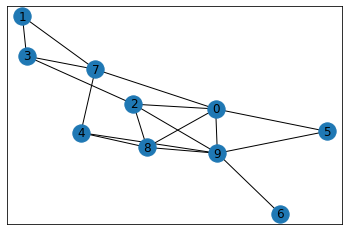

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from cliques import *

# Compute boundary map for checks
SIZE = 10 # graph size
P_VAL = 0.3 # edge ret. prob.

G = nx.erdos_renyi_graph(SIZE, P_VAL)
sc = SimplicialCollection()
sc.constructFromGraph(G, return_for_all_edges=True)

for k in range(0, 5):
    if k > 0:
        b = sc.kBoundaryMap(k)
        print("k = " + str(k) + " boundary\n", b)
    else:
        print("k = " + str(k) + " boundary is zero matrix")
    cl = sc.kCombinatorialLaplacian(k)
    print("k = " + str(k) + " combinatorial Laplacian\n", cl)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)
plt.show()


In [24]:
help(cirq.sample)

Help on function sample in module cirq.sim.mux:

sample(program: 'cirq.Circuit', *, noise: 'cirq.NOISE_MODEL_LIKE' = None, param_resolver: Union[cirq.study.resolver.ParamResolver, NoneType] = None, repetitions: int = 1, dtype: Type[numpy.number] = <class 'numpy.complex64'>, seed: 'cirq.RANDOM_STATE_OR_SEED_LIKE' = None) -> cirq.study.result.Result
    Simulates sampling from the given circuit.
    
    Args:
        program: The circuit to sample from.
        noise: Noise model to use while running the simulation.
        param_resolver: Parameters to run with the program.
        repetitions: The number of samples to take.
        dtype: The `numpy.dtype` used by the simulation. Typically one of
            `numpy.complex64` or `numpy.complex128`.
            Favors speed over precision by default, i.e. uses `numpy.complex64`.
        seed: The random seed to use for this simulator.



In [25]:
help(cirq.study.resolver.ParamResolver)

Help on class ParamResolver in module cirq.study.resolver:

class ParamResolver(builtins.object)
 |  ParamResolver(param_dict: 'cirq.ParamResolverOrSimilarType' = None)
 |  
 |  Resolves parameters to actual values.
 |  
 |  A parameter is a variable whose value has not been determined.
 |  A ParamResolver is an object that can be used to assign values for these
 |  variables.
 |  
 |  ParamResolvers are hashable.
 |  
 |  Attributes:
 |      param_dict: A dictionary from the ParameterValue key (str) to its
 |          assigned value.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self) -> bool
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getitem__(self, key: Union[sympy.core.basic.Basic, float, str]) -> 'cirq.TParamVal'
 |  
 |  __hash__(self) -> int
 |      Return hash(self).
 |  
 |  __init__(self, param_dict: 'cirq.ParamResolverOrSimilarType' = None) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self) -> It